[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aymgal/herculens_workspace/blob/dev/notebooks/herculens__Starting_guide.ipynb)

# Starting guide for a basic use of `Herculens`

This notebooks show a basic example of simulating and modeling a lensed source using fully differentiable capabilities of `Herculens` based on JAX.

What is included:
- Simulation of an HST-like observation of a strong lens
- Full modeling of the simulated data with smooth profiles
- Estimation of parameter covariances via the Fisher information matrix (FIM)
- Posterior sampling via Hamiltonian Monte Carlo (HMC with `blackjax`)
- Nested sampling for computing the Bayesian evidence (using `dynesty`)


__authors__: @aymgal, @austinpeel

__last update__: 15/07/22

In [5]:
import os
running_on_colab = os.path.exists('/content')
if running_on_colab:
    # Installing requirements and dependencies
    !pip install --quiet git+https://github.com/aymgal/herculens.git@dev-aym emcee jaxns dynesty getdist

In [1]:
# Plotting
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm, LogNorm, Normalize, TwoSlopeNorm
plt.rc('image', interpolation='none')

# Basic imports
import numpy as np
from copy import deepcopy
import time
from functools import partial
from pprint import pprint
from getdist import plots as gd_plots
from getdist import MCSamples
from getdist.gaussian_mixtures import GaussianND

# JAX-related
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)
import jaxns
from jaxns import NestedSampler
from jaxns.prior_transforms import PriorChain, UniformPrior
import dynesty
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc

# Herculens
from herculens.Coordinates.pixel_grid import PixelGrid
from herculens.Instrument.psf import PSF
from herculens.Instrument.noise import Noise
from herculens.LightModel.light_model import LightModel
from herculens.MassModel.mass_model import MassModel
from herculens.LensImage.lens_image import LensImage
from herculens.Parameters.parameters import Parameters
from herculens.Parameters.covariance import FisherCovariance
from herculens.Inference.loss import Loss
from herculens.Inference.optimization import Optimizer
from herculens.Inference.sampling import Sampler
from herculens.Analysis.plot import Plotter
from herculens.Util import image_util, param_util, plot_util

# Baseline font soze
FS = 18

# Plotting engine
plotter = Plotter(base_fontsize=FS, flux_vmin=1e-3, flux_vmax=1e0, res_vmax=4)

## 1. Simulate an observation of strong lens

### Define the coordinates grid

In [2]:
npix = 80  # number of pixel on a side
pix_scl = 0.08  # pixel size in arcsec
half_size = npix * pix_scl / 2
ra_at_xy_0 = dec_at_xy_0 = -half_size + pix_scl / 2  # position of the (0, 0) with respect to bottom left pixel
transform_pix2angle = pix_scl * np.eye(2)  # transformation matrix pixel <-> angle
kwargs_pixel = {'nx': npix, 'ny': npix,
                'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0,
                'transform_pix2angle': transform_pix2angle}

# create the PixelGrid class
pixel_grid = PixelGrid(**kwargs_pixel)
xgrid, ygrid = pixel_grid.pixel_coordinates
extent = pixel_grid.extent

print(f"image size : ({npix}, {npix}) pixels")
print(f"pixel size : {pix_scl} arcsec")
print(f"x range    : {xgrid[0, 0], xgrid[0, -1]} arcsec")
print(f"y range    : {ygrid[0, 0], ygrid[-1, 0]} arcsec")

image size : (80, 80) pixels
pixel size : 0.08 arcsec
x range    : (-3.16, 3.16) arcsec
y range    : (-3.16, 3.16) arcsec


### Point spread function (PSF)

For simplicity we assume here a Gaussian PSF.

In [3]:
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': 0.3}
psf = PSF(**kwargs_psf)

### Noise

In [4]:
# exposure time, used for estimating the shot noise
exp_time = 2000
# standard deviation of the background noise
sigma_bkd = 0.005

kwargs_noise = {'background_rms': sigma_bkd, 'exposure_time': exp_time}
noise = Noise(npix, npix, **kwargs_noise)

### Lens galaxy

We assume a SIE embedded in an external shear

In [5]:
# Lens mass
lens_mass_model_input = MassModel(['SIE', 'SHEAR'])

# position of the lens
cx0, cy0 = 0., 0.
# position angle, here in degree
phi = 8.0
# axis ratio, b/a
q = 0.75
# conversion to ellipticities
e1, e2 = param_util.phi_q2_ellipticity(phi * np.pi / 180, q)
# external shear orientation, here in degree
phi_ext = 54.0
# external shear strength
gamma_ext = 0.03 
# conversion to polar coordinates
gamma1, gamma2 = param_util.shear_polar2cartesian(phi_ext * np.pi / 180, gamma_ext)
kwargs_lens_input = [
    {'theta_E': 1.4, 'e1': e1, 'e2': e2, 'center_x': cx0, 'center_y': cy0},  # SIE
    {'gamma1': gamma1, 'gamma2': gamma2, 'ra_0': 0.0, 'dec_0': 0.0}  # external shear
]
#pprint(kwargs_lens_input)


# Lens light
lens_light_model_input = LightModel(['SERSIC_ELLIPSE'])
kwargs_lens_light_input = [
    {'amp': 8.0, 'R_sersic': 1.0, 'n_sersic': 3., 'e1': e1, 'e2': e2, 'center_x': cx0, 'center_y': cy0}
]
#pprint(kwargs_lens_light_input)

### Source galaxy

In [6]:
source_model_input = LightModel(['SERSIC'])
kwargs_source_input = [
    {'amp': 8.0, 'R_sersic': 0.1, 'n_sersic': 1.5, 'center_x': 0.05, 'center_y': 0.1}
]

### Generate the lens image

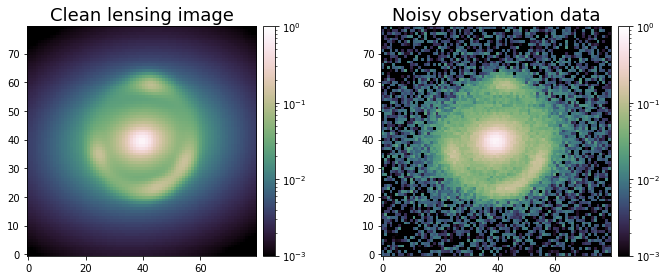

In [7]:
# Generate a lensed image based on source and lens models
kwargs_numerics_simu = {'supersampling_factor': 5}
lens_image_simu = LensImage(pixel_grid, psf, noise_class=noise,
                         lens_mass_model_class=lens_mass_model_input,
                         source_model_class=source_model_input,
                         lens_light_model_class=lens_light_model_input,
                         kwargs_numerics=kwargs_numerics_simu)

kwargs_all_input = dict(kwargs_lens=kwargs_lens_input,
                        kwargs_source=kwargs_source_input,
                        kwargs_lens_light=kwargs_lens_light_input)
image = lens_image_simu.model(**kwargs_all_input)

data = lens_image_simu.simulation(**kwargs_all_input, compute_true_noise_map=True, noise_seed=42)

# visualize simulated products
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
img1 = ax1.imshow(image, origin='lower', norm=plotter.norm_flux, cmap=plotter.cmap_flux)
plot_util.nice_colorbar(img1)
ax1.set_title("Clean lensing image", fontsize=FS)
img2 = ax2.imshow(data, origin='lower', norm=plotter.norm_flux, cmap=plotter.cmap_flux)
ax2.set_title("Noisy observation data", fontsize=FS)
plot_util.nice_colorbar(img2)
fig.tight_layout()
plt.show()

In [8]:
# inform the plotter of the data and, if any, the true source 
plotter.set_data(data)

source_input = lens_image_simu.source_surface_brightness(kwargs_source_input, de_lensed=True, unconvolved=True)
plotter.set_ref_source(source_input)

## 2. Lens modeling

For this example we assume the same models as in the simulated data.

In [9]:
kwargs_numerics_fit = {'supersampling_factor': 2}  # increase for better results, here it's 1 for runtime
lens_image = LensImage(deepcopy(pixel_grid), deepcopy(psf), noise_class=deepcopy(noise),
                         lens_mass_model_class=deepcopy(lens_mass_model_input),
                         source_model_class=deepcopy(source_model_input),
                         lens_light_model_class=deepcopy(lens_light_model_input),
                         kwargs_numerics=kwargs_numerics_fit)

### Decide on the parameters to optimize

We set our initial values for the parameters we want to optimise, and set fixed parameters (here we fix source parameters to the truth). We also set possible priors among `'uniform'` and `'gaussian'` for a subset of parameters.

We simulate a initial guess of parameters by slightly perturbing some of the parameters.

In [10]:
kwargs_init = {
    'kwargs_lens': [
        {'theta_E': 1.38, 'e1': e1+0.01, 'e2': e2-0.01, 'center_x': 1e-3, 'center_y': 1e-3}, 
        {'gamma1': gamma1-0.01, 'gamma2': gamma2+0.01}
    ],
    'kwargs_lens_light': [
        {'amp': 1e1, 'R_sersic': 1.1, 'n_sersic': 3., 'e1': e1+0.01, 'e2': e2-0.01, 'center_x': 1e-3, 'center_y': 1e-3}, 
    ],
    'kwargs_source': [
        {'amp': 1e1, 'R_sersic': 0.04, 'n_sersic': 1.7, 'center_x': 0.04, 'center_y': 0.12}
    ],
}
kwargs_prior = {
    'kwargs_lens': [
        # just for showing how to set priors on a subset of parameters
        {'theta_E': ['gaussian', 1.4, 1.], 'center_x': ['uniform', -0.3, 0.3], 'center_y': ['uniform', -0.3, 0.3]},
        {}
    ],
    'kwargs_lens_light': [{}],
    'kwargs_source': [{}],
}
kwargs_fixed = {
    # we fix origin of the external shear profile as we don't want to optimize it
    'kwargs_lens': [
        {}, 
        {'ra_0': 0., 'dec_0': 0.}
    ],
    'kwargs_lens_light': [{}],
    'kwargs_source': [{}],
}
kwargs_joint = {
    'lens_with_lens_light': [
        [
            (0, 0), [('center_x', 'center_x'), ('center_y', 'center_y')]
        ]
    ]
}
parameters = Parameters(lens_image, kwargs_init, kwargs_fixed, 
                        kwargs_joint=kwargs_joint,
                        kwargs_prior=kwargs_prior)
print("Number of fitted parameters:", parameters.num_parameters)
print("Parameter names:", parameters.names)

#print("prior types:", parameters.prior_types)
#print("lower/upper bounds (for uniform priors):", *parameters.bounds)

# save the array of input parameters for latter use
params_input = parameters.kwargs2args(kwargs_all_input)

Number of fitted parameters: 17
Parameter names: ['theta_E-lens-0', 'e1-lens-0', 'e2-lens-0', 'gamma1-lens-1', 'gamma2-lens-1', 'amp-source-0', 'R_sersic-source-0', 'n_sersic-source-0', 'center_x-source-0', 'center_y-source-0', 'amp-lens_light-0', 'R_sersic-lens_light-0', 'n_sersic-lens_light-0', 'e1-lens_light-0', 'e2-lens_light-0', 'center_x-lens_light-0', 'center_y-lens_light-0']


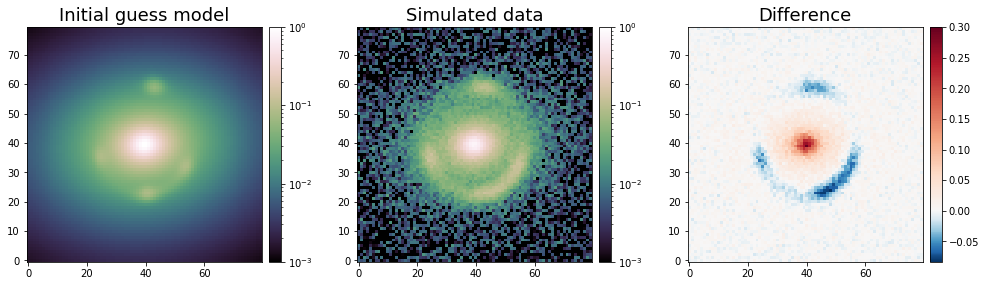

In [11]:
# visualize initial guess
initial_model = lens_image.model(**kwargs_init)

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
ax = axes[0]
ax.set_title("Initial guess model", fontsize=FS)
im = ax.imshow(initial_model, origin='lower', norm=plotter.norm_flux, cmap=plotter.cmap_flux)
plot_util.nice_colorbar(im)
ax = axes[1]
ax.set_title("Simulated data", fontsize=FS)
im = ax.imshow(data, origin='lower', norm=plotter.norm_flux, cmap=plotter.cmap_flux)
plot_util.nice_colorbar(im)
ax = axes[2]
ax.set_title("Difference", fontsize=FS)
im = ax.imshow(initial_model - data, origin='lower', norm=TwoSlopeNorm(0), cmap=plotter.cmap_res)
plot_util.nice_colorbar(im)
fig.tight_layout()
plt.show()

### Define the loss function

By default, it follows from the assumption of Gaussian errors so it is equal to half the generalized $\chi^2$ of the data given the model.

You can also choose which prior types to include (`None`, `'gaussian'`, `'uniform'` or both).

In [12]:
loss = Loss(data, lens_image, parameters, likelihood_type='chi2', prior_terms=['gaussian'])

Just for fun, let's check the gradient and hessian matrix of the loss function, evaluated at the input values.

_Remember than the first time these methods are called, the runtime is longer as it has not been JIT-compiled yet!_

In [13]:
loss.gradient(params_input).block_until_ready()

DeviceArray([ 5.29312070e-01,  7.54073631e+02,  1.49290280e+03,
             -3.63584848e+02, -2.36608369e+03,  1.51564019e+00,
             -3.65997210e+01,  2.56342581e-01, -8.92467255e+02,
             -1.08936025e+03, -4.49096167e+01, -3.72383087e+02,
             -6.83050494e+01,  4.80281840e+02,  3.24536743e+02,
              2.04160019e+03,  8.30517544e+02], dtype=float64)

In [14]:
# uncomment this line to compute the Hessian matrix
#loss.hessian(params_input).block_until_ready()[:4, :4]

### Set the optimizer to minimize the loss function

In [15]:
optimizer = Optimizer(loss, parameters)

Below we use the method from `scipy.optimize.mininize`. In `Herculens`, the supported methods are:
- `'Nelder-Mead'`: uses no analytical gradient;
- `'BFGS'`: uses gradient;
- `'Newton-CG'`/`'trust-krylov'`/`'trust-constr'`: uses gradient and hessian-vector product. In addition, `'trust-constr'` uses bounds from uniform prior consistently within the optimization;
- `'trust-exact'` (uses gradient and hessian).

Setting `use_exact_hessian_if_allowed=True` forces methods that use the hessian-vector product to use the full hessian instead.

In [16]:
best_fit, logL, extra_fields, runtime \
    = optimizer.minimize(method='BFGS', restart_from_init=True,
                         use_exact_hessian_if_allowed=False,
                         return_param_history=True)
print(f"Runtime: {runtime}")

# save a copy of optimized parameters
kwargs_final = deepcopy(parameters.best_fit_values(as_kwargs=True))

minimize.BFGS: 100%|██████████| 1/1 [00:04<00:00,  4.47s/it]

Runtime: 4.474132299423218


Note that you also can use a __multi-start gradient descent__ with the option `multi_start_from_prior=True` (and additional settings `num_multi_start` and `seed_multi_start`), in order to call several times the optimizers with different initial values. However you need to define prior distributions using in the `kwargs_prior`, as initial guesses are then drawn from that prior distribution.

In [17]:
extra_fields.keys()

dict_keys(['result_class', 'jac', 'hess', 'hess_inv', 'best_fit_index', 'loss_history', 'loss_history_list', 'param_history', 'param_history_list'])

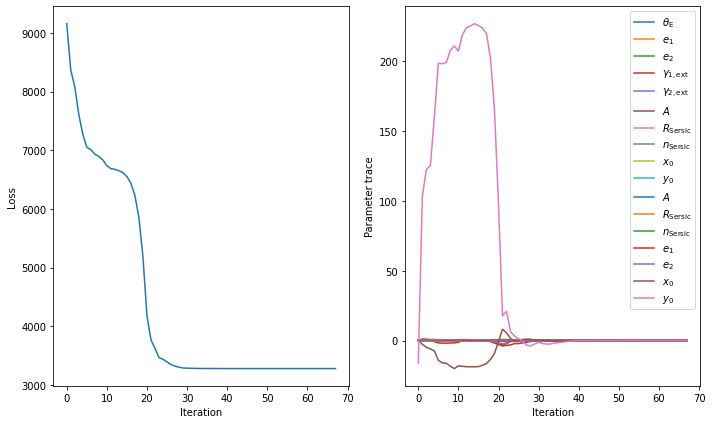

In [18]:
plot_util.plot_minimize_history(parameters, extra_fields)

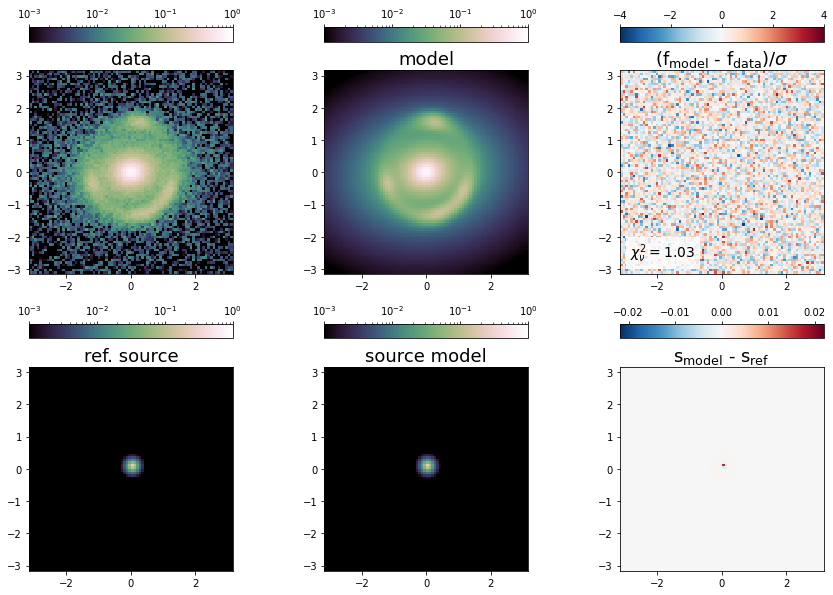

In [19]:
fig = plotter.model_summary(lens_image, kwargs_final, show_source=True)

In [20]:
# print resulting parameters
print("BEST-FIT VALUES:")
pprint(kwargs_final)

print("="*80)

# compare to input values
print("INPUT VALUES:")
pprint(kwargs_all_input)

BEST-FIT VALUES:
{'kwargs_lens': [{'center_x': array(-0.00183166),
                  'center_y': array(0.00028963),
                  'e1': array(0.12820074),
                  'e2': array(0.0355558),
                  'theta_E': array(1.39873662)},
                 {'dec_0': 0.0,
                  'gamma1': array(-0.01440899),
                  'gamma2': array(0.02723146),
                  'ra_0': 0.0}],
 'kwargs_lens_light': [{'R_sersic': array(0.96990373),
                        'amp': array(8.44252808),
                        'center_x': array(-0.00183166),
                        'center_y': array(0.00028963),
                        'e1': array(0.13694632),
                        'e2': array(0.03687348),
                        'n_sersic': array(2.93952502)}],
 'kwargs_source': [{'R_sersic': array(0.10519239),
                    'amp': array(7.23350133),
                    'center_x': array(0.04925374),
                    'center_y': array(0.09989246),
                    

## Parameter covariance matrix from the Fisher information

Computing the true inverse Hessian


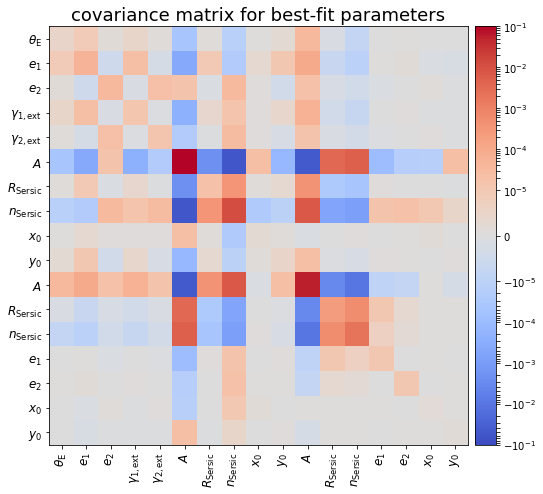

In [21]:
recompute_hessian = True

if extra_fields['hess_inv'] is not None and not recompute_hessian:
    print("Using approximated inverse Hessian from the optimizer")
    cov_matrix = extra_fields['hess_inv']
    
else:
    print("Computing the true inverse Hessian")
    model_covar = FisherCovariance(parameters, loss)
    model_covar.compute_fisher_information(parameters.best_fit_values())
    #fisher_matrix = model_covar.fisher_matrix
    cov_matrix = model_covar.covariance_matrix


plt.figure(figsize=(8, 8))
plt.title("covariance matrix for best-fit parameters", fontsize=FS)
im = plt.imshow(cov_matrix, origin='upper', cmap='coolwarm', 
                norm=SymLogNorm(linthresh=1e-5, linscale=1, vmin=-1e-1, vmax=1e-1))
plt.xticks(range(parameters.num_parameters), parameters.symbols, rotation='vertical', fontsize=12)
plt.yticks(range(parameters.num_parameters), parameters.symbols, rotation='horizontal', fontsize=12)
plot_util.nice_colorbar(im)
plt.show()

## Posterior sampling with HMC

Previously we found a point-estimate of the maximum _a posteriori_ set of parameters. Thanks to auto-diff, we also accessed a first-order approxomation of their uncertainties, as a covariance matrix estimated from inverse Fisher information matrix (FIM).

We are now interested to compute the underlying full joint posterior over our set of parameters. For this we can run a __Hamiltonian Monte Carlo (HMC)__ that takes advantage of the gradients of the loss function to dramatically improve sampling efficiency.

In [22]:
sampler = Sampler(loss, parameters)

For the sake of limite runtime, we set the number of samples to somewhat low value (200). In a real-world scenario you may want to go higher. However, you'll be surprise that even with 200 samples, HMC is able to efficiently sample the full posterior distribution thanks to gradient information, which is far from being the case with (stochastic) MCMC.

In [23]:
seed_hmc = 10
inv_mass_matrix = None # can also be the inverse of the Hessian matrix (i.e. the FIM)

num_warmup, num_samples = 50, 200
samples_hmc, logL_hmc, extra_fields_hmc, runtime \
    = sampler.hmc_blackjax(seed_hmc, num_warmup=num_warmup, num_samples=num_samples, num_chains=1, 
                           restart_from_init=False, sampler_type='NUTS', use_stan_warmup=True)
print(f"Runtime: {runtime}")
print(f"Samples shape: {samples_hmc.shape}")

Runtime: 2065.9370391368866
Samples shape: (200, 17)


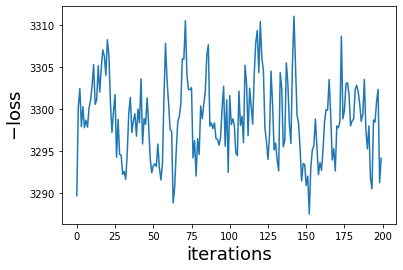

In [24]:
plt.plot(logL_hmc)
plt.xlabel("iterations", fontsize=FS)
plt.ylabel("$-$loss", fontsize=FS)
plt.show()

## Compute Bayesian evidence with Nested Sampling

The following still need some fine-tuning of parameters. Just know that nested sampling is feasible, and faster than other codes thanks to JIT-compilation and optionally gradient knowledge!

In [25]:
# We first need to specify lower and upper bounds for nested sampling
# so we simply update our Parameters instance

# We decide to set the bounds to +/- X sigmas from the median of the HMC posteriors
# this will save computation time, and we don't want to explore very low-posterior regions anyway
nsigmas = 6
kw_medians = parameters.args2kwargs(np.median(samples_hmc, axis=0))
kw_sigmas = parameters.args2kwargs(np.std(samples_hmc, axis=0))
#kw_medians = parameters.best_fit_values(as_kwargs=True)
#kw_sigmas  = model_covar.get_kwargs_sigma()

kwargs_prior_bounds = deepcopy(kwargs_init)  # just to start with a pre-populated dictionnary
for model_key, model_kwargs in kwargs_init.items():
    for profile_idx, profile_kwargs in enumerate(model_kwargs):
        for param_key, param_value in profile_kwargs.items():
            med = kw_medians[model_key][profile_idx][param_key]
            sig = kw_sigmas[model_key][profile_idx][param_key]
            low = med - nsigmas * sig
            upp = med + nsigmas * sig
            kwargs_prior_bounds[model_key][profile_idx][param_key] = ['uniform', float(low), float(upp)]

#pprint(kwargs_prior_bounds)

In [26]:
parameters.update_fixed(kwargs_fixed, kwargs_prior=kwargs_prior_bounds)  # kwargs_fixed did not change
print("Check that bounds are ok:\n", parameters.bounds)
print(parameters.num_parameters)

Check that bounds are ok:
 (array([ 1.38462235e+00,  8.17431103e-02, -1.56805640e-03, -3.68535262e-02,
        4.09546849e-03,  4.62764355e+00,  8.19622548e-02,  9.71061911e-01,
        3.98616637e-02,  8.57007550e-02,  7.16906689e+00,  8.91202040e-01,
        2.69075869e+00,  1.16270392e-01,  1.78977664e-02, -9.80663256e-03,
       -6.18342208e-03]), array([1.41234900e+00, 1.71027324e-01, 7.27909046e-02, 6.25292959e-03,
       5.03446060e-02, 1.03593138e+01, 1.24910777e-01, 2.17135150e+00,
       5.81638240e-02, 1.13158570e-01, 9.62677953e+00, 1.05059976e+00,
       3.19450767e+00, 1.58052101e-01, 5.54334113e-02, 5.72725485e-03,
       6.60525120e-03]))
17


## Dynesty

In [27]:
lowers, uppers = parameters.bounds

# below: `u` is the unit cube, `x` are parameters

@jax.jit
def prior_u(u):
    # prior transform from unit cube to parameter cube
    x = lowers + (uppers - lowers) * u
    return x

@jax.jit
def loglike_x(x):
    # log-likelihood to maximise
    return -loss(x)

@jax.jit
def grad_x(x):
    # gradient of the log-likelihood wrt to x
    return jax.grad(loglike_x)(x)

@jax.jit
def grad_u(u):
    # gradient of the log-likelihood wrt to u (i.e. includes jacobian between u and x)
    return jax.grad(loglike_x)(u) * (uppers - lowers)

In [28]:
# option 1: hamiltonian slicing, use the gradient of the log-l wrt x, and compute numerically the jacobian wrt to u
#sample, kwargs_sample = 'hslice', dict(gradient=grad_x, compute_jac=True)

# option 2: hamiltonian slicing, use the gradient of the log-l directly wrt u
#sample, kwargs_sample = 'hslice', dict(gradient=grad_u, compute_jac=False)

# option 3: random slicing (do not use the gradient): it is faster and (according to Dynesty's doc), more reliable...
sample, kwargs_sample = 'rslice', {}

nested_sampler = dynesty.NestedSampler(loglike_x, prior_u, 
                                       parameters.num_parameters, 
                                       nlive=10 * parameters.num_parameters, # this seems to give good results
                                       sample=sample, **kwargs_sample)
t0 = time.time()
nested_sampler.run_nested(dlogz=0.1) #maxiter=None, maxcall=None, dlogz=None, logl_max=inf
runtime = time.time() - t0
print("Nested sampling runtime:", runtime)

5578it [03:29, 26.60it/s, +170 | bound: 79 | nc: 1 | ncall: 133911 | eff(%):  4.292 | loglstar:   -inf < -3282.864 <    inf | logz: -3313.295 +/-  0.549 | dlogz:  0.001 >  0.100]

Nested sampling runtime


In [29]:
results = nested_sampler.results
results.summary()

Summary
nlive: 170
niter: 5578
ncall: 133911
eff(%):  4.292
logz: -3313.295 +/-  0.549


/Users/aymericg/anaconda3/envs/py3jax/lib/python3.7/site-packages/dynesty/plotting.py:245: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axes[i].set_ylim([ymin, ymax])


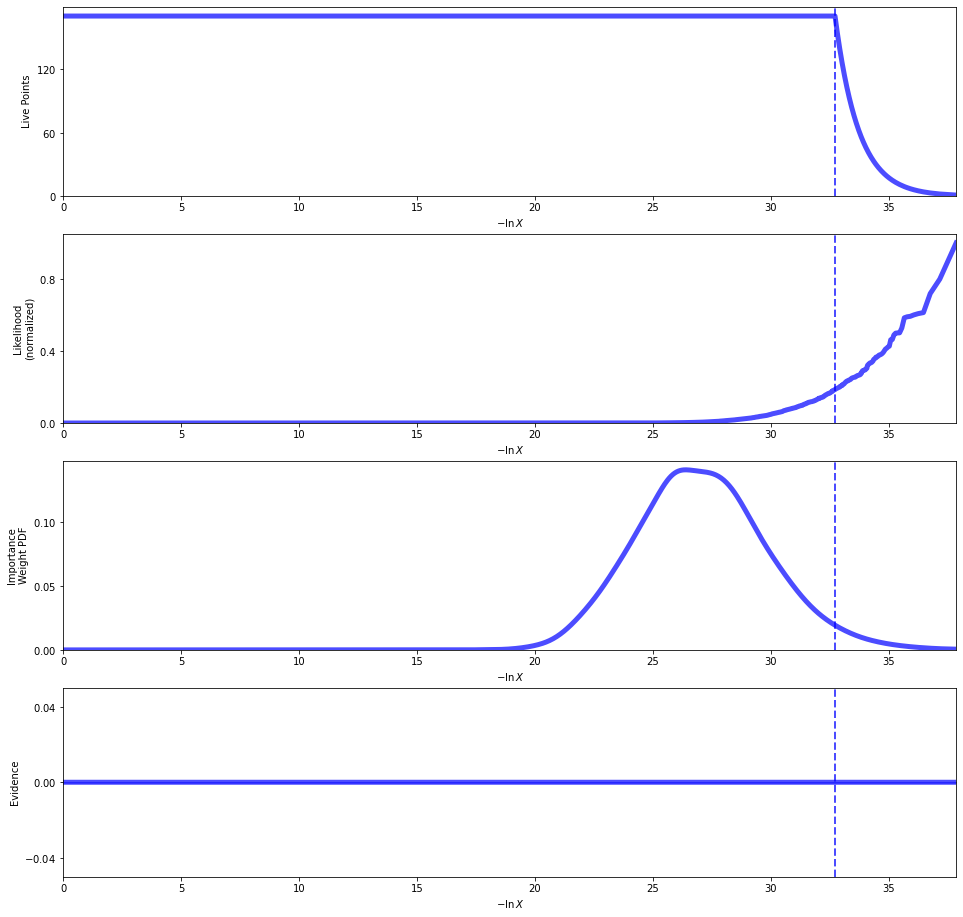

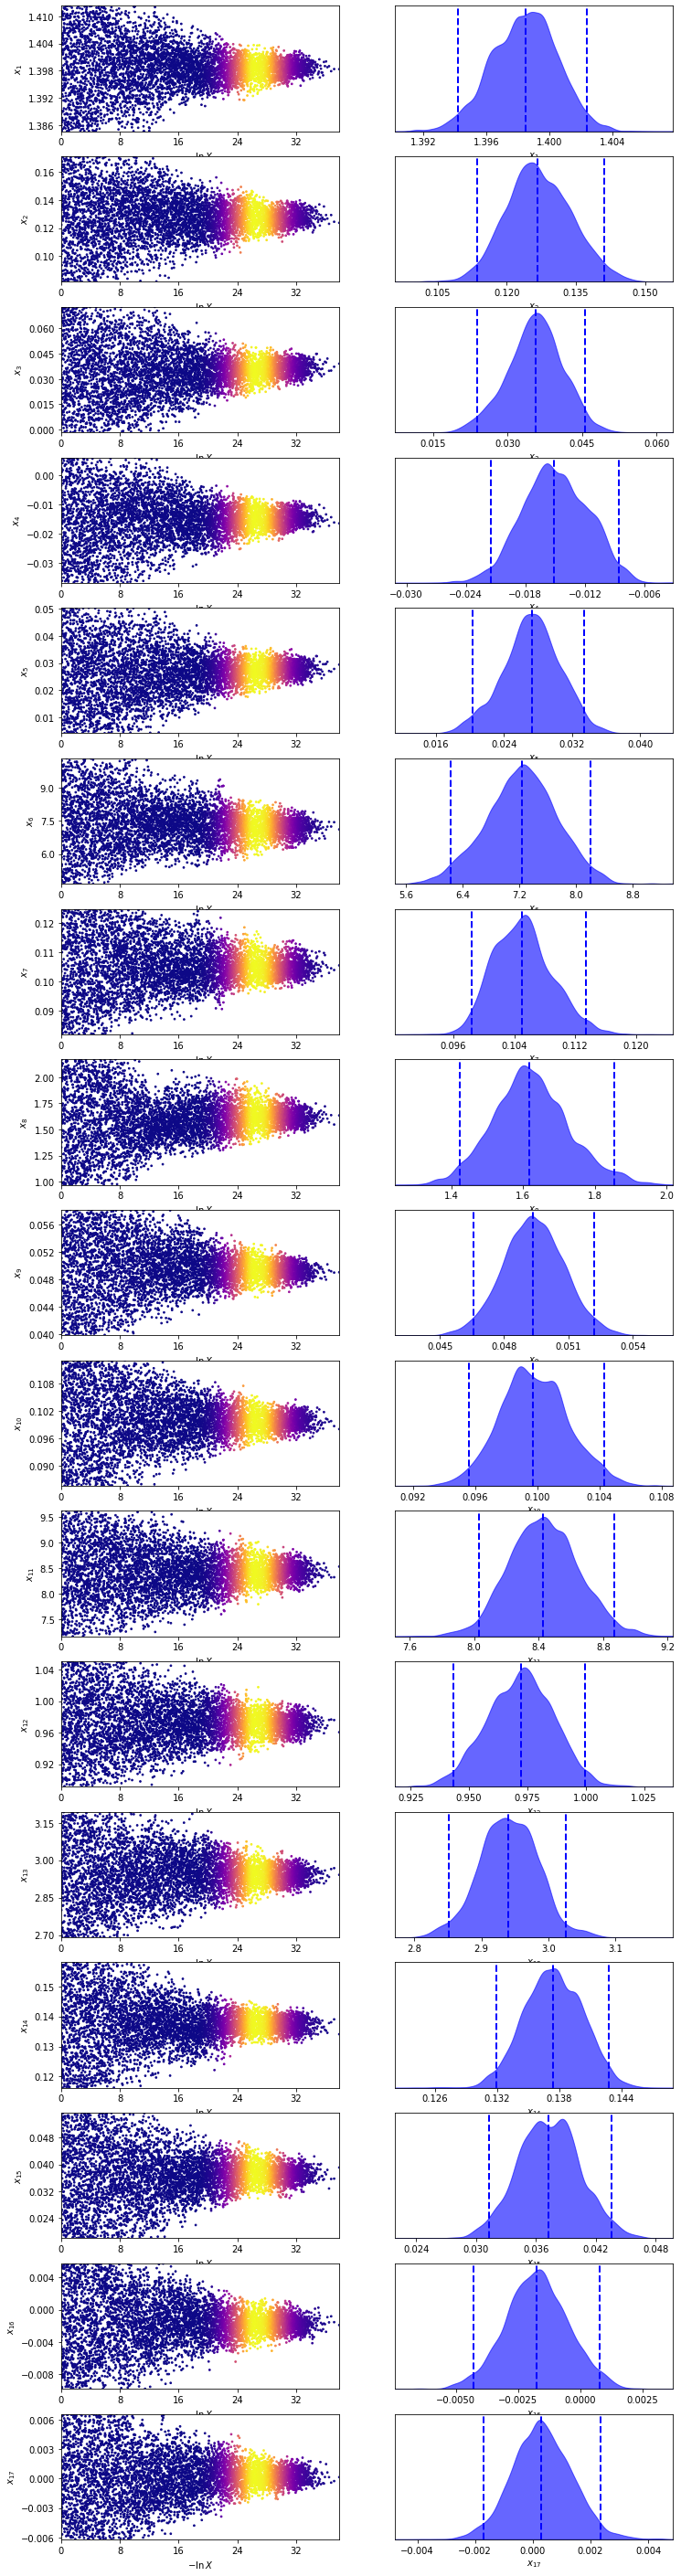

In [30]:
results = nested_sampler.results

# Plot a summary of the run.
rfig, raxes = dyplot.runplot(results)

# Plot traces and 1-D marginalized posteriors.
tfig, taxes = dyplot.traceplot(results)

# Plot the 2-D marginalized posteriors.
#cfig, caxes = dyplot.cornerplot(results) # we do that ourselves

In [31]:
# Extract sampling results.
samples_w = results.samples  # samples
weights = np.exp(results.logwt - results.logz[-1])  # normalized weights

# Compute 10%-90% quantiles.
quantiles = [dyfunc.quantile(samps, [0.1, 0.9], weights=weights)
             for samps in samples_w.T]

# Compute weighted mean and covariance.
mean, cov = dyfunc.mean_and_cov(samples_w, weights)

# Resample weighted samples.
samples_ns_equal = dyfunc.resample_equal(samples_w, weights)

# Generate a new set of results with statistical+sampling uncertainties.
#results_sim = dyfunc.simulate_run(results)

#### JAXNS

_For some reason I can't make this sampler to work... fortunately there is Dynesty!_

## Compare posterior distributions

- obtained from the FIM
- via Hamiltonian Monte Carlo sampling
- via Nested Sampling

Removed no burn in
Removed no burn in


WARNING[2022-07-15 19:10:13,528]: 2D kernel density bandwidth optimizer failed for amp-lens_light-0, R_sersic-lens_light-0. Using fallback width: f(a) and f(b) must have different signs


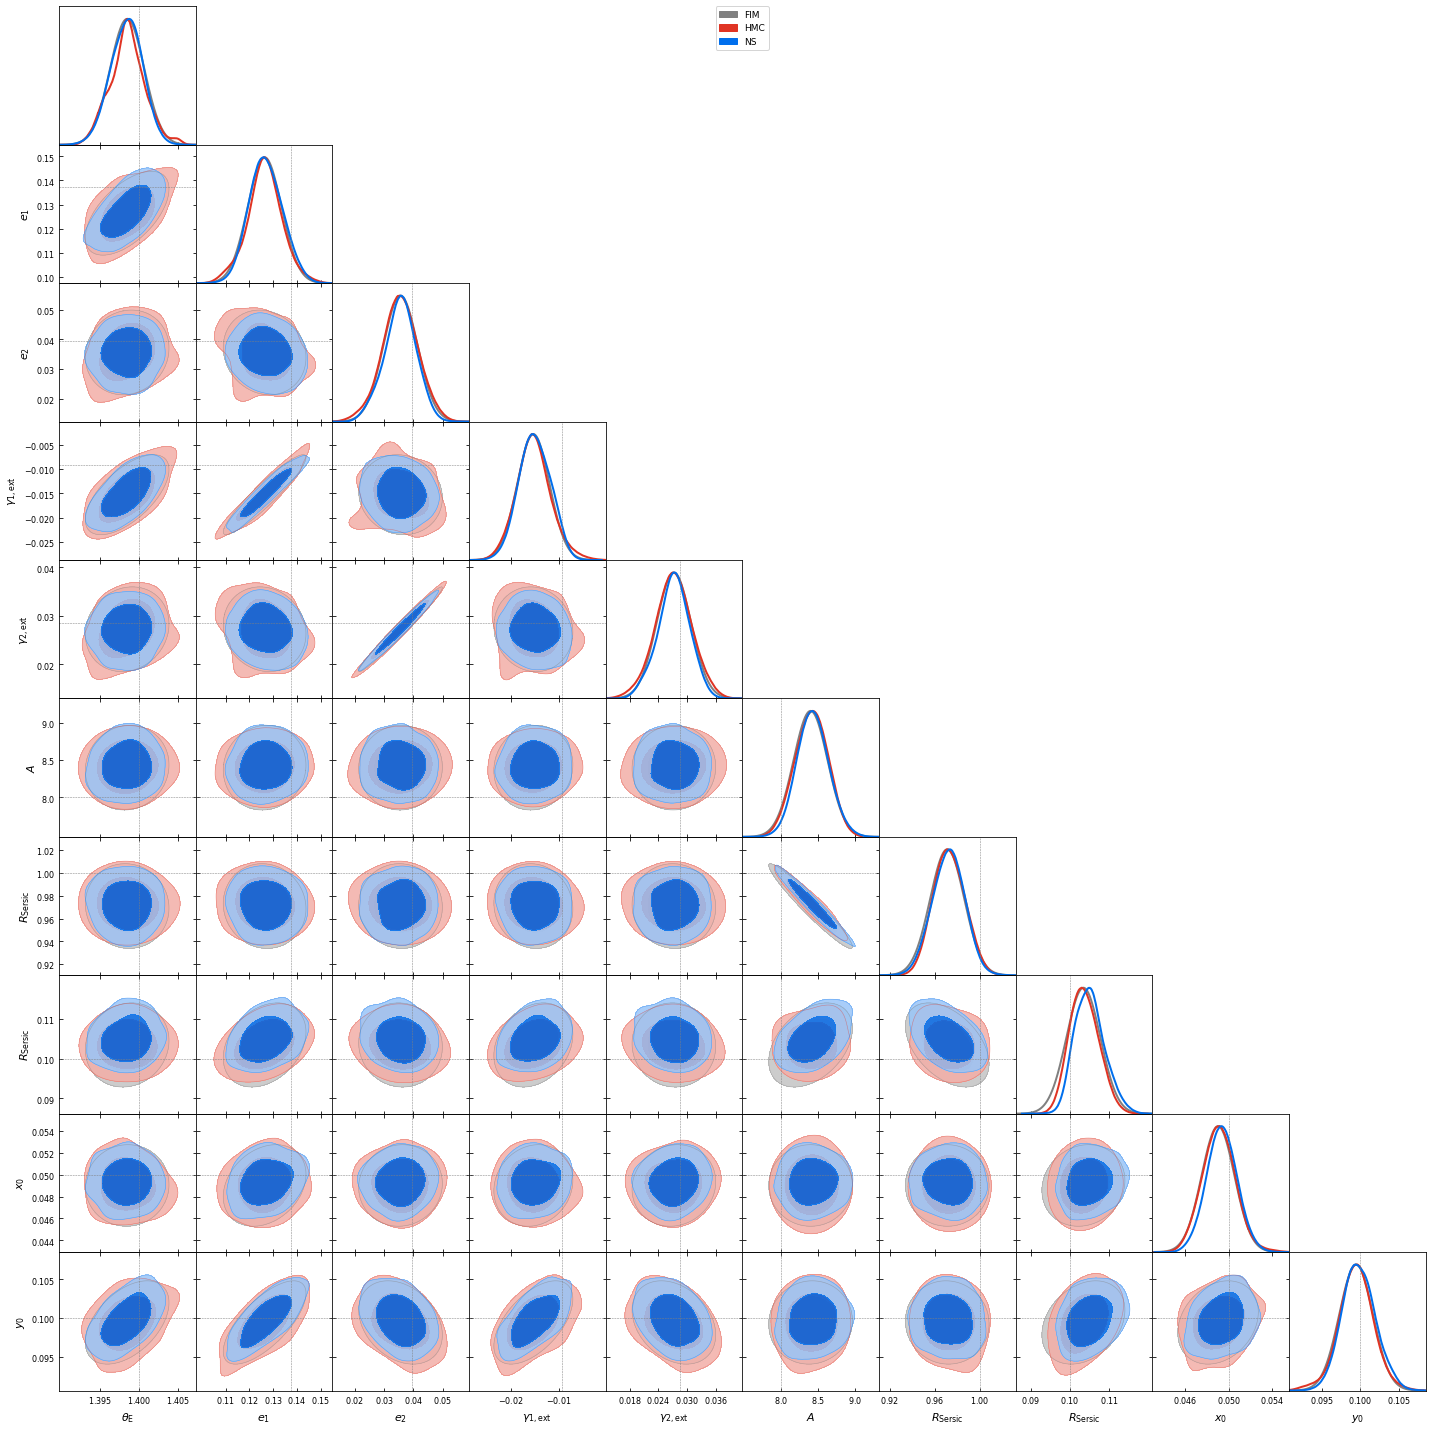

In [32]:
# format labels and markers for getdist
labels = [l.replace('$', '') for l in parameters.symbols] # remove '$' for compliance with getdist
markers_input = {n: val for n, val in zip(parameters.names, params_input)}  # input values

# create a NDGaussian object from covariance matrix estimated from the FIM
gaussians = GaussianND(parameters.best_fit_values(), cov_matrix, labels=labels, names=parameters.names)

# create MCSamples object for storing HMC samples
mc_samples = MCSamples(samples=samples_hmc, names=parameters.names, labels=labels)

# create MCSamples object for storing NS samples
ns_samples = MCSamples(samples=samples_ns_equal, names=parameters.names, labels=labels)

# select a subset of parameters to display
displayed_params = [
    'theta_E-lens-0', 'e1-lens-0', 'e2-lens-0', 'gamma1-lens-1', 'gamma2-lens-1', 
    'amp-lens_light-0', 'R_sersic-lens_light-0', 
    'R_sersic-source-0', 'center_x-source-0', 'center_y-source-0'
]

# create corner plot
g = gd_plots.get_subplot_plotter(subplot_size=2)
g.triangle_plot([gaussians, mc_samples, ns_samples], displayed_params, 
                legend_labels=["FIM", "HMC", "NS"],
                markers=markers_input, filled=True, contour_lws=2)
plt.show()